# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.zip', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
data = df.copy()
data = data.isna()
for col in data.columns:
    value_counts = data[col].value_counts()
    if len(value_counts) == 2:
        print(f'столбец {col}, пропусков {value_counts[1]}')

столбец balance, пропусков 25


### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
data = df.copy()
def get_int(args):
    if type(args) == float:
        return np.nan
    else:
        #list_split = args.split(',')
        list_split = args.replace(',00', '').replace(' $', '').replace(' ', '')
        return float(list_split)

data['balance'] = data['balance'].apply(get_int)
round(data['balance'].mean(), 3)


1529.129

### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
median = data['balance'].median()
data = data.fillna(median)
round(data['balance'].mean(), 3)

1526.936

### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
moda = data['job'].mode()
def get_unknown(args):
    if args == 'unknown':
        return moda[0]
    else:
        return args
data['job'] = data['job'].apply(get_unknown)
moda = data['education'].mode()
data['education'] = data['education'].apply(get_unknown)


In [8]:
mask1 = data['job'] == data['job'].mode()[0]
mask2 = data['education'] == data['education'].mode()[0]
round(data[mask1 & mask2]['balance'].mean(), 3)

1598.883

### Задание 6

-2241.0
4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10104


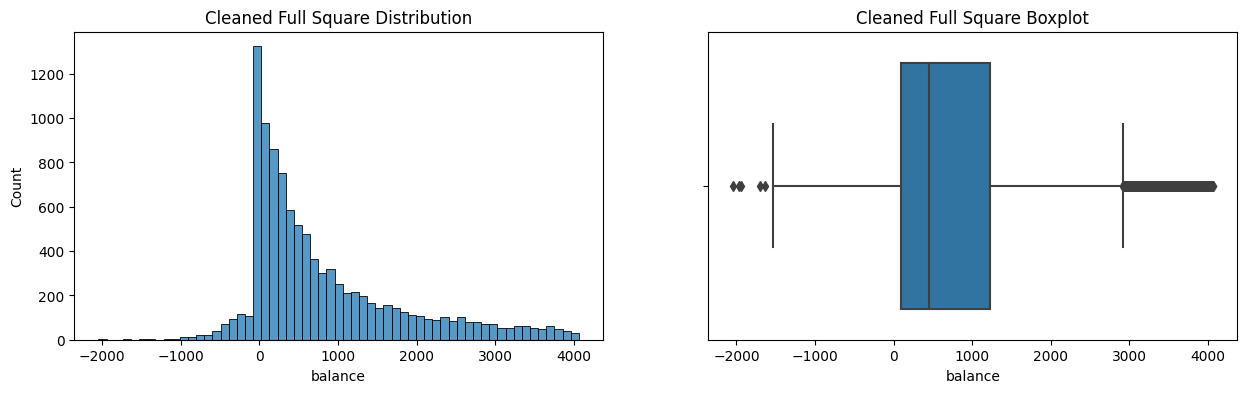

In [9]:
# удалите все выбросы для признака balance
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    print(lower_bound)
    print(upper_bound)
    outliers = data[(x<lower_bound) | (x> upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(data, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

In [10]:
# удаление выбросов по методу z-отклонения
del_outliers = outliers.index
for i in del_outliers:
        data=data.drop([i])

## Часть 2:  Разведывательный анализ

### Задание 1

In [11]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
import plotly
import plotly.express as px

for col in data.columns:
    count_data = (data[col].value_counts().reset_index())
    fig = px.bar(
        data_frame=count_data, #датафрейм
        x=col, #ось x
        y="count", #ось y
        color=col, #расцветка в зависимости от страны
        text = 'count', #текст на столбцах
        orientation='v', #ориентация графика
        height=500, #высота
        width=1000, #ширина
        title='соотношение классов' #заголовок
    )
    #отображаем его
    fig.show()

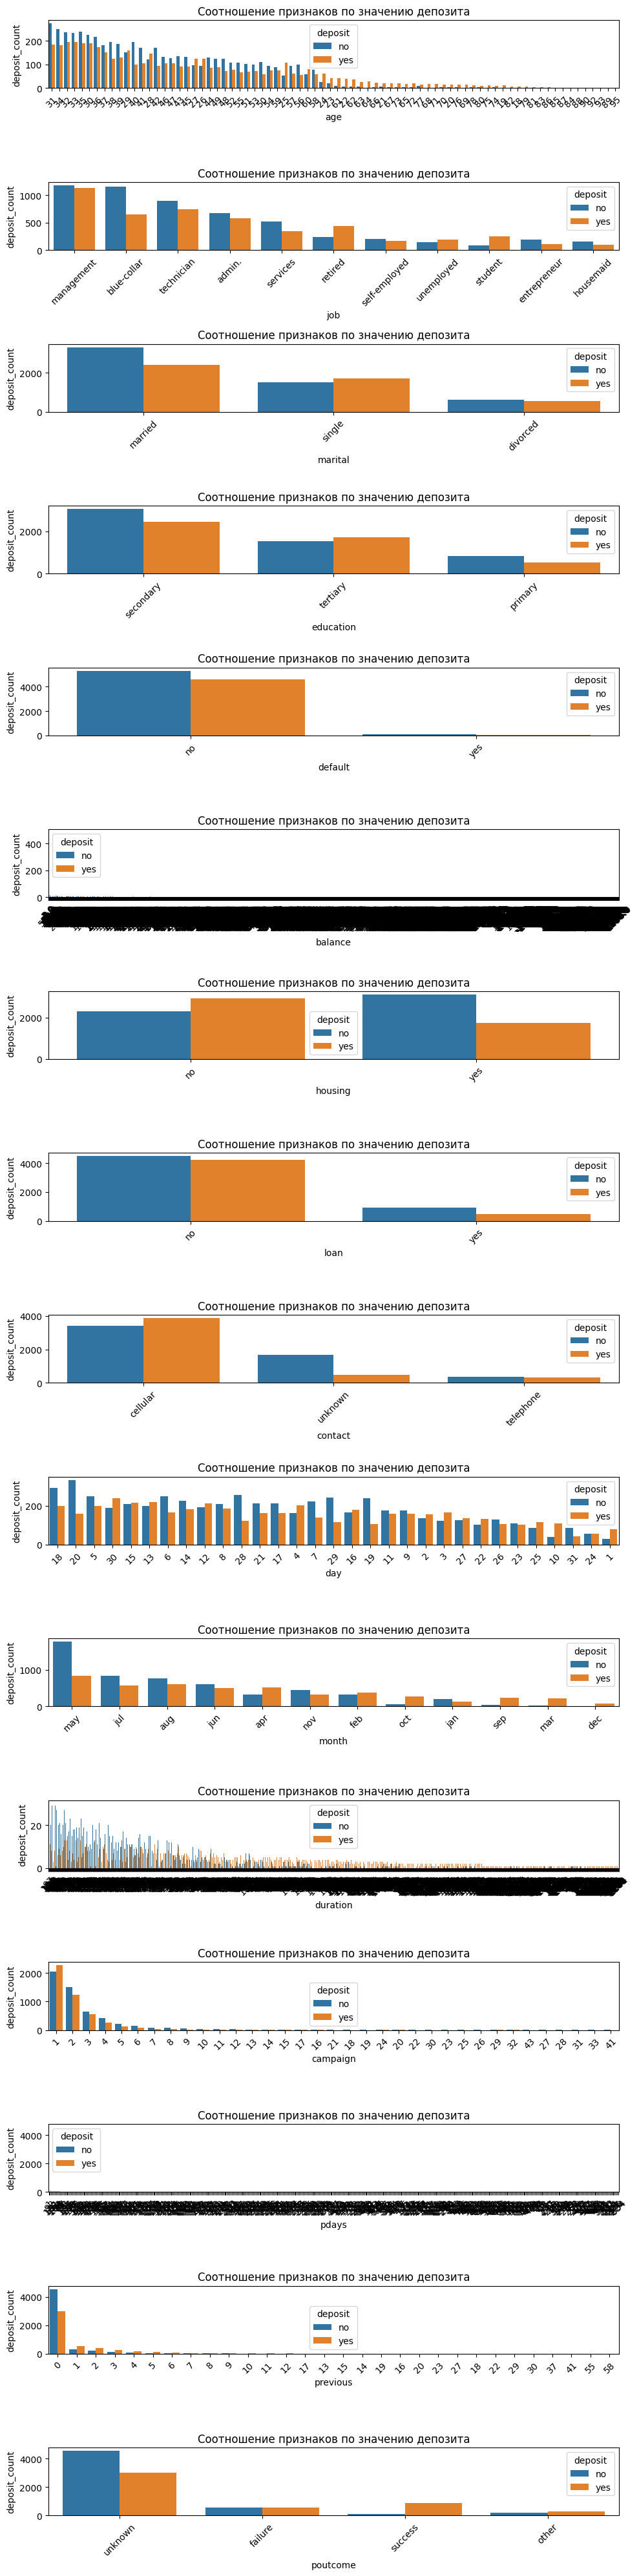

In [12]:
list_col = list(data.columns)
list_col.remove('deposit')

n = len(list_col) #число категориальных признаков
fig, axes = plt.subplots(n, 1, figsize=(10, 40)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(list_col):
    gr_data = data.groupby(feature)['deposit'].agg(['count']).sort_values(by='count', ascending=False).reset_index()
    list_gr = list(gr_data[feature])
    gr_data = data.groupby([feature, 'deposit']).agg({'deposit': 'count'}).rename(columns={'deposit': 'deposit_count'}).reset_index()

    #fig = plt.figure(figsize=(7, 3))
    barplot = sns.barplot(
        data=gr_data,
        x=feature,
        y='deposit_count',
        hue='deposit',
        order = list_gr, ax=axes[i]
    )
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45)
    barplot.set_title('Cоотношение признаков по значению депозита')
plt.tight_layout() #выравнивание графиков

### Задания 2 и 3

In [11]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [11]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
data['balance'] = data['balance'].astype(int)
list_object = []
list_int = []
for col in data.columns:
    if data[col].dtype == object:
        list_object.append(col)
    else:
        list_int.append(col)

data_int = data[list_int]
data_int.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [13]:
import plotly
import plotly.express as px

for col in data_int.columns:
    count_data = (data_int[col].value_counts().reset_index())
    fig = px.bar(
        data_frame=count_data, #датафрейм
        x=col, #ось x
        y="count", #ось y
        color=col, #расцветка в зависимости от страны
        text = 'count', #текст на столбцах
        orientation='v', #ориентация графика
        height=500, #высота
        width=1000, #ширина
        title='соотношение классов' #заголовок
    )
    #отображаем его
    fig.show()

### Задания 4 и 5

In [12]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
list_object = []
list_int = []
for col in data.columns:
    if data[col].dtype != object:
        list_object.append(col)
    else:
        list_int.append(col)

data_int = data[list_int]
data_int.describe()
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Задание 6

In [13]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
data_yes = data[data['deposit'] == 'yes']
print('yes', '\n', data_yes['poutcome'].value_counts(), '\n')
data_no = data[data['deposit'] != 'yes']
print('no', '\n', data_no['poutcome'].value_counts())

yes 
 poutcome
unknown    3008
success     861
failure     547
other       265
Name: count, dtype: int64 

no 
 poutcome
unknown    4562
failure     562
other       216
success      84
Name: count, dtype: int64


### Задание 7

In [14]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
data_no['month'].value_counts().head(1)

month
may    1776
Name: count, dtype: int64

### Задание 8

In [15]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_group(age):
    age = int(age)
    if age < 30:
        return 1
    elif 40 > age >= 30:
        return 2
    elif 50 > age >= 40:
        return 3
    elif 60 > age >= 50:
        return 4
    else:
        return 5
data['age_group'] = data['age'].apply(get_group)

In [16]:
# построить график для понятной интерпретации и ответа на вопрос
data_yes = data[data['deposit'] == 'yes']
print('yes', '\n', data_yes['age_group'].value_counts(), '\n')
data_no = data[data['deposit'] != 'yes']
print('no', '\n', data_no['age_group'].value_counts())

yes 
 age_group
2    1716
3     938
1     861
4     670
5     496
Name: count, dtype: int64 

no 
 age_group
2    2245
3    1444
4     984
1     594
5     157
Name: count, dtype: int64


### Задания 9 и 10

In [17]:
def get_deposit_int(args):
    if args == 'yes':
        return 1
    else:
        return 0
data['deposit_int'] = data['deposit'].apply(get_deposit_int)

def get_deposit_yes(args):
    if args == 'yes':
        return 1
    else:
        return 0
data['deposit_yes'] = data['deposit'].apply(get_deposit_yes)
def get_deposit_no(args):
    if args != 'yes':
        return 1
    else:
        return 0
data['deposit_no'] = data['deposit'].apply(get_deposit_no)

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
import plotly.express as px

count_data = (data[['marital', 'deposit_yes', 'deposit_no', 'deposit']].groupby(['marital']).agg({'deposit_yes': 'sum', 'deposit_no': 'sum', 'deposit': 'count'}).reset_index())
fig = px.bar(
    data_frame=count_data, #DataFrame
    x='marital', #ось абсцисс
    y=['deposit_no', 'deposit_yes'], #ось ординат
    text_auto=True,
    barmode='group',
    height=600, #высота
    width=1200, #ширина
    title='Соотношение открывших и неоткрывших депозит в зависимости от Сферы занятости' #заголовок
)
fig.show()

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
count_data = (data[['education', 'deposit_yes', 'deposit_no', 'deposit']].groupby(['education']).agg({'deposit_yes': 'sum', 'deposit_no': 'sum', 'deposit': 'count'}).reset_index())
fig = px.bar(
    data_frame=count_data, #DataFrame
    x='education', #ось абсцисс
    y=['deposit_no', 'deposit_yes'], #ось ординат
    text_auto=True,
    barmode='group',
    height=600, #высота
    width=1200, #ширина
    title='Соотношение открывших и неоткрывших депозит в зависимости от бразования' #заголовок
)
fig.show()

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
count_data = (data[['job', 'deposit_yes', 'deposit_no', 'deposit']].groupby(['job']).agg({'deposit_yes': 'sum', 'deposit_no': 'sum', 'deposit': 'count'}).reset_index())
fig = px.bar(
    data_frame=count_data, #DataFrame
    x='job', #ось абсцисс
    y=['deposit_no', 'deposit_yes'], #ось ординат
    text_auto=True,
    barmode='group',
    height=600, #высота
    width=1200, #ширина
    title='Соотношение открывших и неоткрывших депозит в зависимости от Сферы занятости' #заголовок
)
fig.show()

### Задание 11

In [20]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pivot = data.pivot_table(
    values='deposit_int',
    columns='marital',
    index='education',
    aggfunc='sum'
)
pivot.columns = pivot.columns.astype('string')
display(pivot)

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


## Часть 3: преобразование данных

### Задание 1

In [21]:
# преобразуйте уровни образования
from sklearn import preprocessing

data_conv = data.copy()
la_enc = preprocessing.LabelEncoder()
data_conv['education']= la_enc.fit_transform(data_conv['education'])  
data_conv['education'].sum()

11995

### Задания 2 и 3

In [22]:
# преобразуйте бинарные переменные в представление из нулей и единиц
binari_list = ['default', 'housing', 'loan', 'deposit']
la_enc = preprocessing.LabelEncoder()
for col in binari_list:
    data_conv[col] = la_enc.fit_transform(data_conv[col])  

In [23]:
# Задание 4.2
import statistics as stat

round(stat.stdev(data_conv['deposit']), 3)

0.499

In [24]:
# Задание 4.3
binari_list = ['default', 'housing', 'loan']
k = 0
for col in binari_list:
    k = k + data_conv[col].mean()

print(round(k, 3))

0.635


### Задание 4

In [25]:
# создайте дамми-переменные
from sklearn import preprocessing
dummy_list = ['job', 'marital', 'contact', 'month', 'poutcome']
dummy_enc = preprocessing.OneHotEncoder()
for col in dummy_list:
    data_conv = pd.get_dummies(data_conv, columns=[col], dtype=int)
    

### Задания 5 и 6

<Axes: >

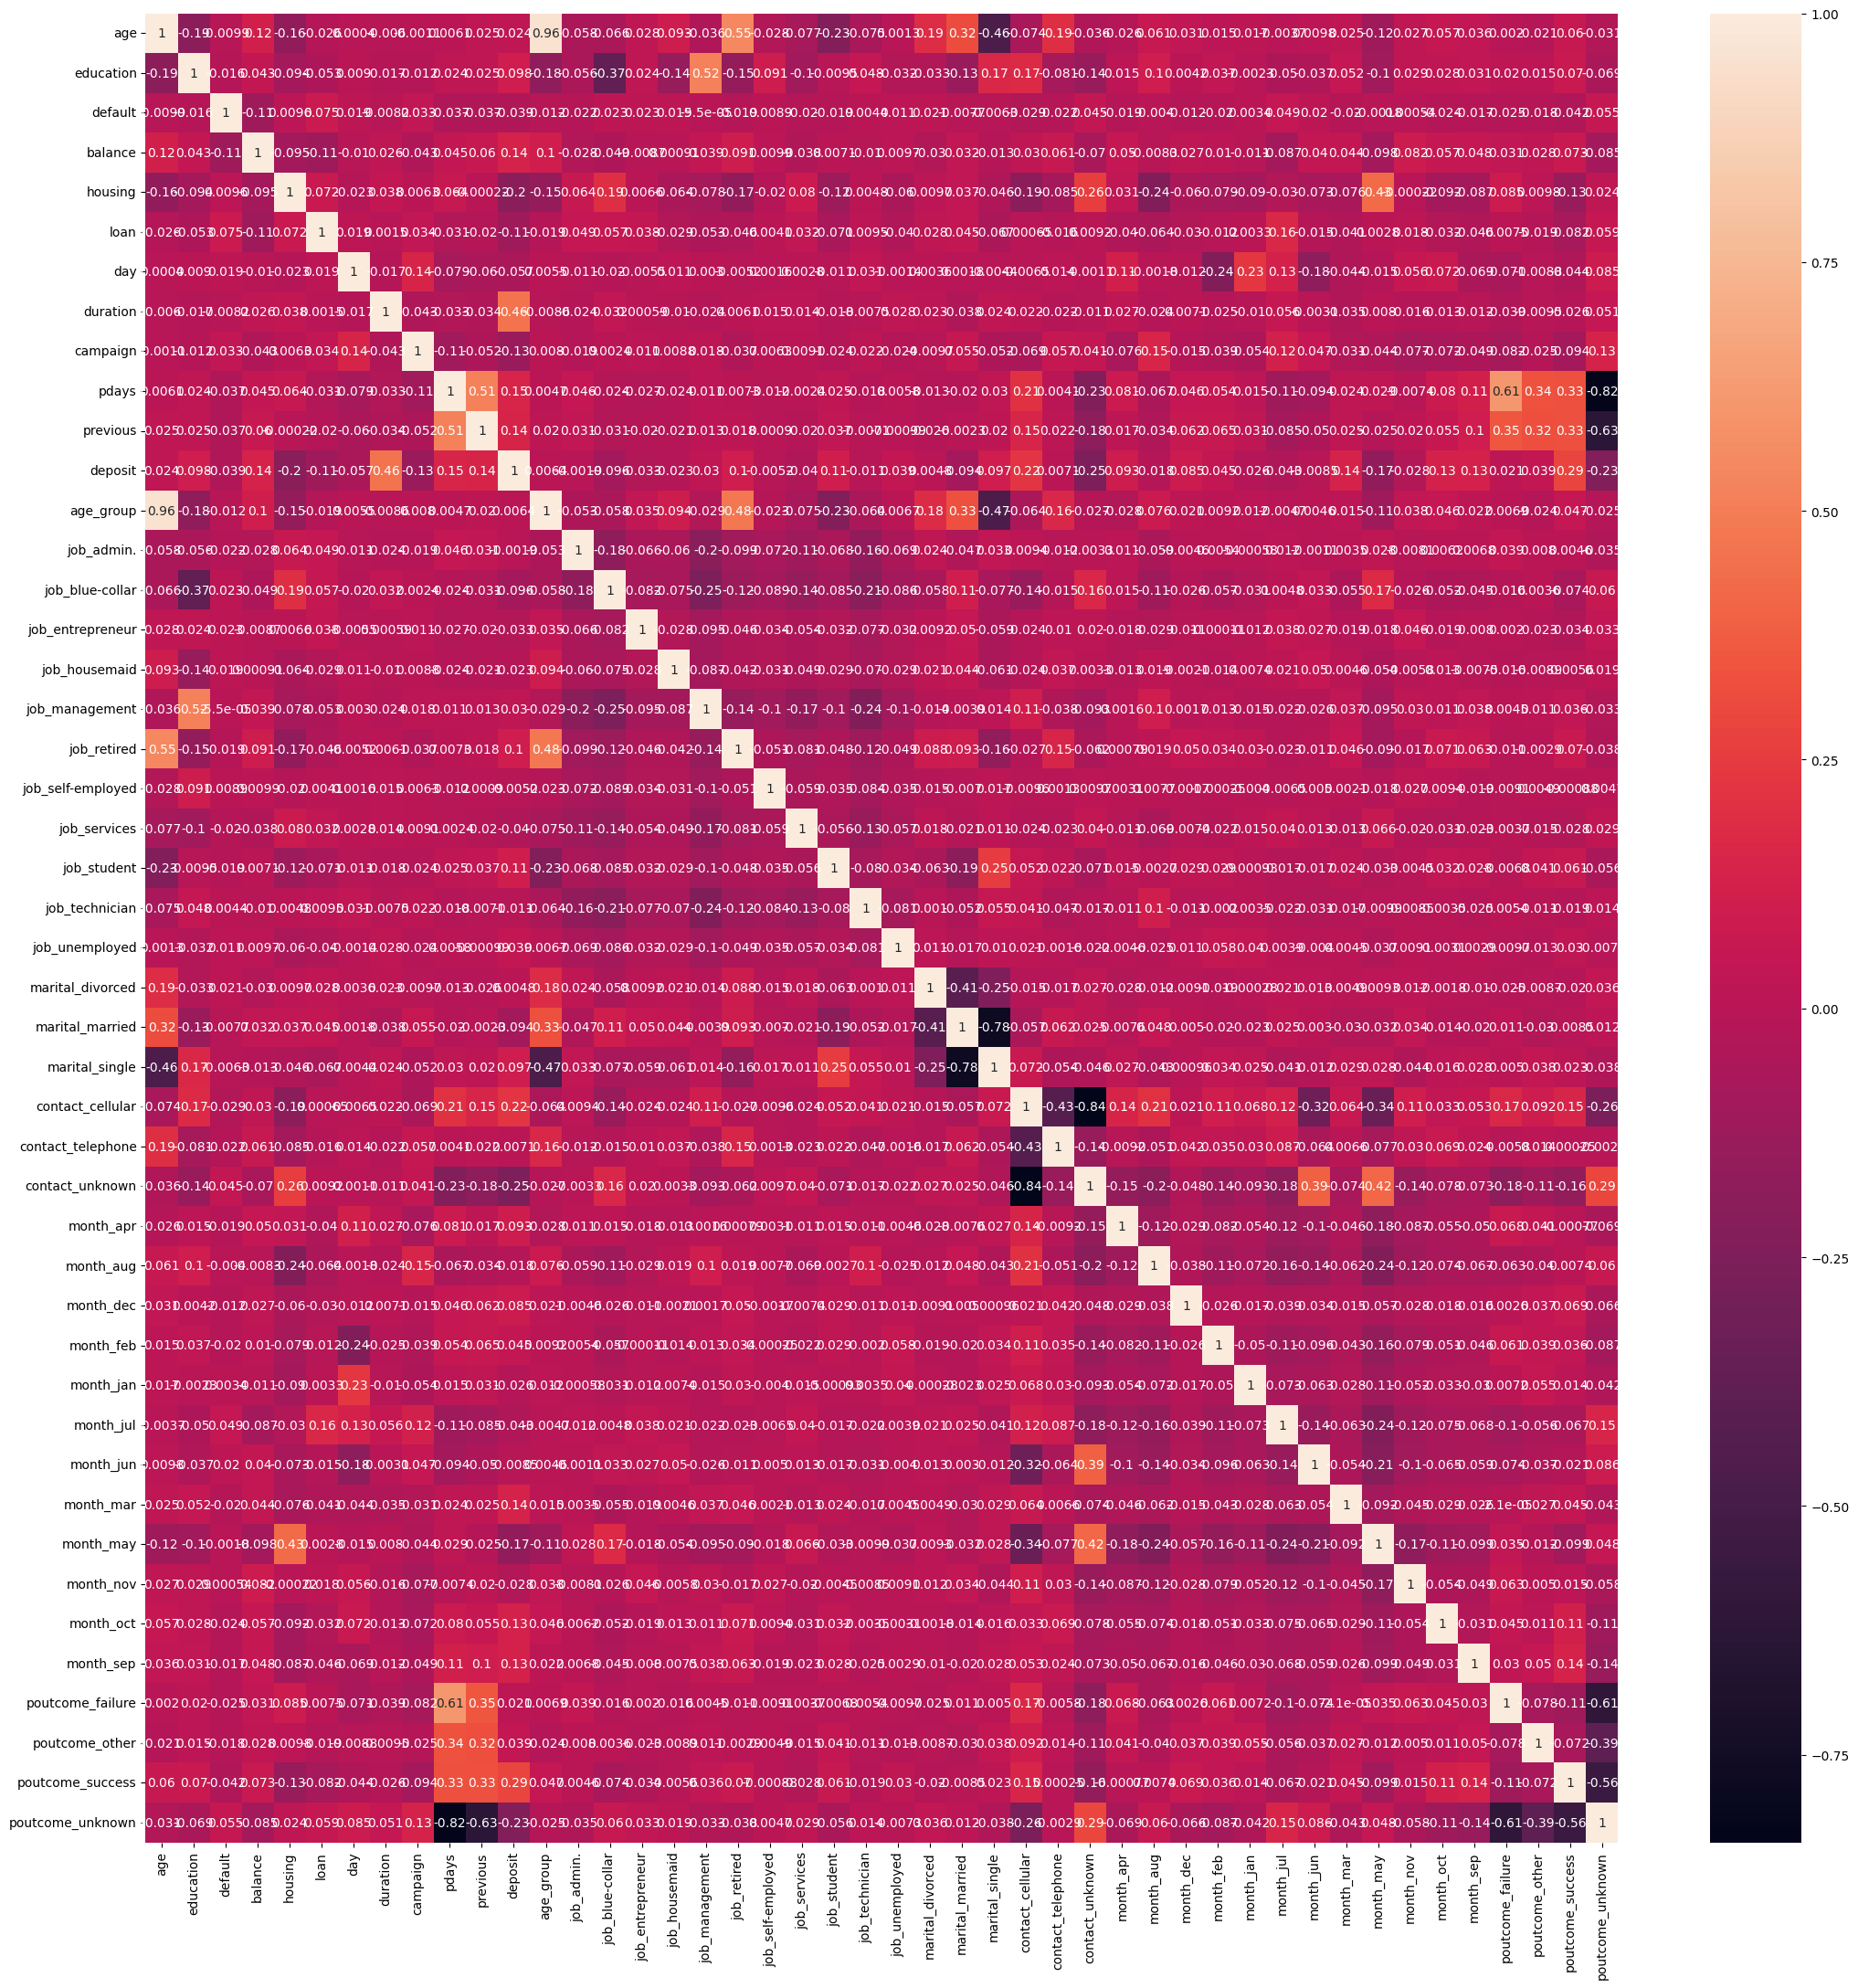

In [26]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
import seaborn as sns 
data_corr = data_conv.copy()
data_corr = data_corr.drop(['deposit_int', 'deposit_yes', 'deposit_no'], axis=1)
fig, ax = plt.subplots(figsize=(26, 26))
sns.heatmap(data_corr.corr(), annot=True) 

### Задания 7 и 8

In [27]:
df = data_conv.copy()
df = df.drop(['deposit_int', 'deposit_yes', 'deposit_no'], axis=1)
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [28]:
# рассчитайте необходимые показатели
print('размер тестовой выборки', len(X_test))
print('среднее значение целевой переменной', round(y_test.mean(), 2))

размер тестовой выборки 3335
среднее значение целевой переменной 0.46


### Задание 9

In [29]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from numpy import array 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

select = SelectKBest(score_func=f_classif, k=15)
z = select.fit_transform(X_train,y_train)
 
print("After selecting best 15 features:", z.shape) 

filter = select.get_support()
features = array(X_train.columns)
 
print("All features:")
print(features)
 
print("Selected best 15:")
print(features[filter])


After selecting best 15 features: (6770, 15)
All features:
['age' 'education' 'default' 'balance' 'housing' 'loan' 'day' 'duration'
 'campaign' 'pdays' 'previous' 'age_group' 'job_admin.' 'job_blue-collar'
 'job_entrepreneur' 'job_housemaid' 'job_management' 'job_retired'
 'job_self-employed' 'job_services' 'job_student' 'job_technician'
 'job_unemployed' 'marital_divorced' 'marital_married' 'marital_single'
 'contact_cellular' 'contact_telephone' 'contact_unknown' 'month_apr'
 'month_aug' 'month_dec' 'month_feb' 'month_jan' 'month_jul' 'month_jun'
 'month_mar' 'month_may' 'month_nov' 'month_oct' 'month_sep'
 'poutcome_failure' 'poutcome_other' 'poutcome_success' 'poutcome_unknown']
Selected best 15:
['balance' 'housing' 'loan' 'duration' 'campaign' 'pdays' 'previous'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [32]:
X_train_best = pd.DataFrame(X_train, columns=features[filter])
X_test_best = pd.DataFrame(X_test, columns=features[filter])



In [34]:
# нормализуйте данные с помощью minmaxsxaler
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
df_mm_train = mm_scaler.fit_transform(X_train_best)
df_mm_tr = pd.DataFrame(df_mm_train, columns=X_train_best.columns)

df_mm_test = mm_scaler.fit_transform(X_test_best)
df_mm_ts = pd.DataFrame(df_mm_test, columns=X_test_best.columns)


In [35]:
round(df_mm_ts['balance'].mean(), 2)

0.46

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [36]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаем объект класса логистическая регрессия
from sklearn import linear_model #линейные модели
from sklearn import metrics

log_reg_full = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg_full.fit(df_mm_tr, y_train)
#Делаем предсказание класса
y_pred = log_reg_full.predict(df_mm_ts)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.81      0.82      0.81      3335
weighted avg       0.82      0.82      0.82      3335



### Задания 2,3,4

In [37]:
#Создаём объект класса DecisionTreeClassifier
acc_list = []

for i in range(1, 10):
    dt_clf_2d = tree.DecisionTreeClassifier(
        criterion='entropy', 
        max_depth=i,
        random_state=42
                                            )
    #Обучаем дерево решений по алгоритму CART
    dt_clf_2d.fit(df_mm_tr, y_train)
    y_pred = dt_clf_2d.predict(df_mm_ts)
    print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)), 'precision: {:.2f}'.format(metrics.precision_score(y_test, y_pred)), 'recall: {:.2f}'.format(metrics.recall_score(y_test, y_pred)))
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    # print(metrics.classification_report(y_test, y_pred))
#

Accuracy: 0.69 precision: 0.61 recall: 0.89
Accuracy: 0.72 precision: 0.75 recall: 0.60
Accuracy: 0.75 precision: 0.67 recall: 0.91
Accuracy: 0.75 precision: 0.67 recall: 0.91
Accuracy: 0.78 precision: 0.72 recall: 0.86
Accuracy: 0.80 precision: 0.77 recall: 0.82
Accuracy: 0.80 precision: 0.77 recall: 0.83
Accuracy: 0.79 precision: 0.73 recall: 0.87
Accuracy: 0.78 precision: 0.72 recall: 0.87


### Задание 5

In [39]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7],
             'min_samples_split': [2, 5, 7, 10]}

estimator=tree.DecisionTreeClassifier(
        random_state=42,
        criterion='entropy',
            )
grid_search = GridSearchCV(estimator, param_grid, cv=5, n_jobs = -1)  

%time grid_search.fit(df_mm_tr, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(df_mm_ts, y_test)))
y_test_pred = grid_search.predict(df_mm_ts)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Wall time: 3.84 s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [40]:
# обучите на ваших данных случайный лес
from sklearn.ensemble import RandomForestClassifier

estimator= RandomForestClassifier(criterion = 'gini', random_state=42, min_samples_leaf = 5, n_estimators = 100, max_depth = 10)
estimator.fit(df_mm_tr, y_train)
#Делаем предсказание класса
y_pred = estimator.predict(df_mm_ts)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1790
           1       0.76      0.89      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задания 2 и 3

In [41]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42,
    min_samples_leaf = 5 
)

# Обучаем модель
gb.fit(df_mm_tr, y_train)

# Формируем предсказание для тестовой выборки
y_pred  = gb.predict(df_mm_ts)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1790
           1       0.76      0.88      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание 4

In [61]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, StackingClassifier
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('grb',  GradientBoostingClassifier(learning_rate = 0.05, max_depth=5, n_estimators=300, random_state=42, min_samples_leaf = 5)),
    ('dt',  DecisionTreeClassifier(random_state=42, criterion='entropy'))
            ]

# Создаем объект класса стекинг log_reg_full = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
final_estimator = LogisticRegression(random_state=42, solver='sag', max_iter=1000)
reg = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
# Обучаем модель
reg.fit(df_mm_tr, y_train)



StackingClassifier(estimators=[('grb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [63]:
from sklearn.metrics import classification_report, precision_score

y_pred_ = reg.predict(df_mm_ts)

print(metrics.classification_report(y_test, y_pred))
score = precision_score(y_test, y_pred_)
score

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1790
           1       0.76      0.88      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



0.7620650953984287

### Задание 5

In [67]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    min_samples_leaf = 5, #функция потерь
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(df_mm_tr, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(df_mm_ts)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))


from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
selector = RFE(gb, n_features_to_select=5, step=1)
selector = selector.fit(df_mm_ts, y_test)
selector.ranking_

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1790
           1       0.76      0.88      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



array([ 1,  2,  9,  1,  4,  1,  6,  8,  1,  3,  7,  5, 11,  1, 10])

### Задания 6,7,8

In [73]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

random_state =42
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(df_mm_tr, y_train)
  score = metrics.f1_score(y_train, model.predict(df_mm_tr))

  return score

In [74]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-10-22 16:45:50,807] A new study created in memory with name: RandomForestClassifier
[I 2023-10-22 16:45:51,689] Trial 0 finished with value: 0.8431892650959588 and parameters: {'n_estimators': 185, 'max_depth': 20, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8431892650959588.
[I 2023-10-22 16:45:52,380] Trial 1 finished with value: 0.8579421821572895 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8579421821572895.
[I 2023-10-22 16:45:53,141] Trial 2 finished with value: 0.8661270236612703 and parameters: {'n_estimators': 145, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8661270236612703.
[I 2023-10-22 16:45:53,962] Trial 3 finished with value: 0.8515005442388431 and parameters: {'n_estimators': 171, 'max_depth': 14, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8661270236612703.
[I 2023-10-22 16:45:55,155] Trial 4 finished with value: 0.9215006305170239 and parameters: {'n_

Wall time: 15.9 s


In [75]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 199, 'max_depth': 28, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [84]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(df_mm_tr, y_train)
y_train_pred = model.predict(df_mm_tr)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(df_mm_ts)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.92
f1_score на тестовом наборе: 0.82
accuracy_score на тестовом наборе: 0.82
